# Overview of Electricity Generation in the USA based on EIA data

The following is an exercise in using data from the Electricity Information Agency (EIA),
to famialarize myself with both the broad state of the US electrical grid, as well as some elementary data science.

I have converted the bulk data file from (url_here) to a local SQL database.  I used Psycopg2 for direct SQL interaction with that PostGRESQL database.  
I can then efficiently select data from that database, based on geographic region and type of generation.  (While the data should nominally fit into memory in one Pandas dataframe, I found that my computer ran out of memory before it could be loaded.)  

The resulting queries from SQL can then be converted into a Pandas dataframe.  Since the data is of the form
"[[date1,number1],[date2,number]...], as one long string, this is converted into a list, then a Numpy array.
The first column is used to generate a Pandas PeriodIndex (which is then further converted to a DateTimeIndex for plotting reasons).  The second column is then indexed.  The resulting series is output as the elements of a list of series for the desired state, and generation type.  
These results can then be plotted using basic Matplotlib.

In [1]:
import pandas as pd
import numpy as np
import sqlalchemy
import psycopg2
import datetime 
import matplotlib.pyplot as pl
from psycopg2 import sql
from mpl_toolkits.basemap import Basemap  #mapping utility
import pickle   #Useful for caching maps

#from sql_lib import create_conn_and_cur

In [5]:
#Set up connections to SQL database, which was generated from the bulk JSON file.
database_name='US_ELEC'
fname='ELEC'
table_name=fname
engine=sqlalchemy.create_engine("postgresql+psycopg2://localhost/"+database_name)

#make connection to database (which is needed by Pandas), 
# and the cursor which actually executes SQL commands.
conn=psycopg2.connect(dbname=database_name,host='localhost')
conn.set_session(autocommit=True)
cur = conn.cursor()


The following defines some useful functions for grabbing SQL queries, and loading the desired columns into a Pandas DataFrame.

In [20]:
#make safe SQL queries, with deired list of columns in "out_columns".
#Assume we are searching through name for entries with desired type of series, for particular states,
#as well as generation type.
def safe_sql_query(table_name, out_columns, match_names, freq):
    col_query=sql.SQL(' ,').join(map(sql.Identifier,out_columns))
    #make up categories to match the name by.
    namelist=[];
    for namevar in match_names:
        namelist.append(sql.Literal('%'+namevar+'%'))
        #join together these matches with ANDs to match them all
        name_query=sql.SQL(' AND name LIKE ').join(namelist)
    #Total SQL query to select desired columns with features 
    q1 = sql.SQL("SELECT {0} FROM {1} WHERE (name LIKE {2} AND f LIKE {3}) ").format(
        col_query,
        sql.Identifier(table_name),
        name_query,
        sql.Literal(freq))
    return(q1)

# def safe_elec_sql_query(table_name,
#                    out_columns,
#                    series_type='Net generation', 
#                    state='Oregon',
#                    sector='all sectors',
#                    gen_type='hydro',
#                    freq='M'):
#     #make up categories to match the name by. 
#     l1 = sql.Literal(series_type+' :%')
#     l2 = sql.Literal('%: '+state+' :%')
#     l3 = sql.Literal('%'+gen_type+'%')
#     l4 = sql.Literal('%'+sector+'%')
#     #join together these matches with ANDs to match them all
#     like_query=sql.SQL(' AND name LIKE ').join([l1,l2,l3,l4])

#     #Total SQL query to select desired columns with features 
#     q1 = sql.SQL("SELECT {} FROM {} WHERE (name LIKE {} AND f LIKE {}) ").format(
#                 sql.SQL(' ,').join(map(sql.Identifier,out_columns)),
#                 sql.Identifier(table_name),
#                 like_query,
#                 sql.Literal(freq))
#     return(q1)

#Get a dataframe from SQL database for given psycopg2 cursor,
#with desired output columns.     
#Must select data based on series type, state, and type of generation.
def get_dataframe(cur, table_name, out_columns, match_names, freq):
    q = safe_sql_query(table_name,out_columns,match_names,freq)
    cur.execute(q);
    df0=cur.fetchall();
    df = pd.DataFrame(df0,columns=out_columns);
    return df

# def get_elec_dataframe(cur,
#                   out_columns,
#                   table="ELEC",
#                   series_type='Net Generation',
#                   state='Oregon',
#                   sector='all sectors',
#                   gen_type='solar',
#                   freq='M'):
#     q = safe_elec_sql_query(table,out_columns,series_type=series_type,state=state,sector=sector,gen_type=gen_type,freq=freq)
#     cur.execute(q);
#     df0=cur.fetchall();
#     df = pd.DataFrame(df0,columns=out_columns);
#     return df


In [21]:
#Initial readin of SQL dataframes returns 'data' as a string of a list of lists.  
#This function goes row by row, converting that 'data' column
#into a new series, with datetimeindex in 'data2'

# Make a Period Index - really, really easy.
#But plotting is limited with "Periods".  It seems only
#"DateTimeIndices" allow easy combinations.  Use to_timestamp to convert to a DatetimeIndex.
def convert_data(df):
    Nrows=len(df)
    print(Nrows)
    data_array=[];
    for i in range(0,Nrows):
        #check there's actually data there.
        #use next line since the read in dataframe has returned a string.
        print('Converting #',i)
        init_series=np.asarray(eval(df.iloc[i]['data']))
        dat2=init_series[:,1].astype(float);
        f = df.iloc[i]['f']
        periodindex=pd.PeriodIndex(init_series[:,0],freq=f)
        s=pd.Series(dat2,index=periodindex)
        data_array.append(s.to_timestamp())
    return data_array



In [9]:
#Make list of states
states=('Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming')

## United States Seasonal Variation

Let's now survey the seasonal variations in the major sources of generation for the United States as a whole.

In [10]:
out_col=('name','data','start','end','f')
df_tot=pd.DataFrame()

for gen_type in ('nuclear','coal','natural gas','solar','wind','hydro'):
    #for name in ('solar','wind','hydro', 'bio'):
    print('Getting '+gen_type);
    match_names=['Net generation',': Oregon :',gen_type, ': all sectors :'];
    df=get_dataframe(cur,'ELEC',out_col,match_names,freq='M');
    data0=convert_data(df)
    df['data2']=data0
    df_tot=df_tot.append(df)


Getting nuclear
0
Getting coal
1
Converting # 0
Getting natural gas
1
Converting # 0
Getting solar
2
Converting # 0
Converting # 1
Getting wind
1
Converting # 0
Getting hydro
1
Converting # 0


In [38]:
#Plot out each of the rows of a dataframe, with the label given by the name of the row.
def plot_data_frame(df):
    for i in range(0,len(df)):
        pl.plot(df.iloc[i]['data2'],label=df.iloc[i]['name'])
    pl.legend(loc='upper left',bbox_to_anchor=(1,1))
    pl.show()
    return

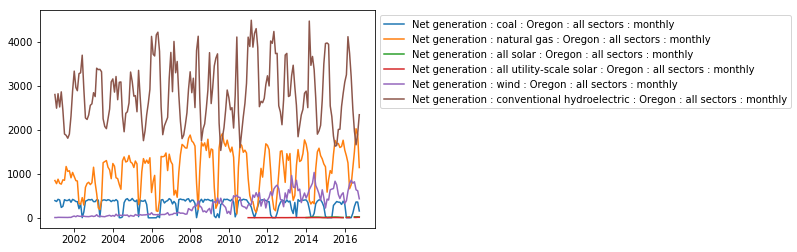

In [12]:
plot_data_frame(df_tot)

Evidently coal, natural gas and nuclear power provide the vast majority of the US's electrical supply.
While coal us is declining (the decline starts in 2008, perhaps Obama or appointee's policies emphasizing cleaner energy?),
that decline is matched by an increase in the use of natural gas.  
Nuclear power is fairly stable.  No new capacity, since the public has an irrational distaste for nuclear power (or is at least deeply suspicious that nuclear power will be safely managed).
It seems that coal and natural gas have the largest seasonal spikes. Coal seems to have spikes in both summer and winter, while natural gas spikes only in summer?

Of the renewables, solar and wind are the dominant providers.  Solar capacity has been approximately constant, while the supply of wind-based electricity generation has been growing over the last decade.  
I think this data does not capture home-owner installed solar, with selling electricity back to the grid.
The other sources, such as hydro and biomass are a small part of the whole.
Note that these are all monthly averages.  These do not capture the short scale fluctuations that can occur on the minute to hour timescale which can impact the usefulness of renewables.  (This variability would to be the obvious reason to invest in energy storage: it can act as a ratchet to capture this fluctuating energy source, and store it in a dependable form)

## Cost of Electricity

Another data set is the price of electricity.

## Geographic variability in 2016

Time to break out some Matplotlib.baseplot goodness for plots of the US.
(This is also directly relevant to the data available from the EIA, since the US is broken into 5 major power regions,
which then interact by buying and selling electricity from one another.)
Using annual data, which states use the most electricity of each type?


Creating Fine BaseMap and storing with pickle


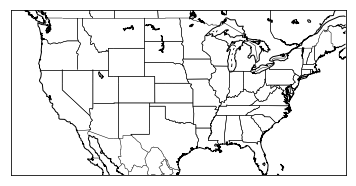

In [6]:
# try:
# 	#Check if pickled(saved) Basemap instance is available - saves lots of time
# 	m=pickle.load(open('usstates.pickle','rb'))
# 	print('Loading Map from pickle')
# except:
#if not, remake the Basemap (costs lots of time)
pl.figure()  
print('Creating Fine BaseMap and storing with pickle')
m=Basemap(projection='merc',llcrnrlon=-130,llcrnrlat=25,\
        urcrnrlon=-65,urcrnrlat=50,resolution='l', \
        lon_0=-115, lat_0=35)
m.drawstates()
m.drawcountries()
#pickle.dump(m,open('map.pickle','wb'),-1)
#actually draw the map
m.drawcoastlines()
pl.show()


## Near Real-time data.

Now to load in some of the actual operating data (which is in a different table in the same database).
Ok, that is not really working, since I screwed up loading the data into the database.


In [7]:
database_name='US_ELEC'
fname='EBA'
table_name=fname
engine2=sqlalchemy.create_engine("postgresql+psycopg2://localhost/"+database_name)
#make connection to database (which is needed by Pandas), 
# and the cursor which actually executes SQL commands.
conn2=psycopg2.connect(dbname=database_name,host='localhost')
conn2.set_session(autocommit=True)
cur2 = conn2.cursor()

In [35]:
def fetch_eba_series(cur2,region,series_type):
    """fetch_eba_series(cur2,region,series_type)
    Call PostgreSQL server to pull up the series relating to
    a given region and type of series.
    
    cur2: psycopg2 cursor object on relevant table
    region: name of the region/ISO we want the series for
    series_type: the type of data series for a given ISO
    """
    print('Getting '+region+':'+series_type);
    df=get_dataframe(cur2,'EBA',out_col,[region,series_type],freq='H');
    data0=convert_data(df)
    df['data2']=data0
    return df

#Read in some representative data.
out_col=('name','data','start','end','f')
df_eba_tot=pd.DataFrame()

region_list=["Northwest (region)",'Southwest (region)','Southeast (region)',\
            'Midwest (region)','Central (region)','California (region)',\
            'Texas','Tennessee','Florida (region)','Carolinas (region)','New York','New England'];
series_type=['Net generation','Demand','demand forecast','retail'];
for region in region_list:
#     for gen_type in series_list:
    series_type='Demand'
    df = fetch_eba_series(cur2,region,series_type)
    print(df['name'])
    df_eba_tot=df_eba_tot.append(df)


Getting Northwest (region):Demand
1
Converting # 0
0    Demand for Northwest (region), Hourly
Name: name, dtype: object
Getting Southwest (region):Demand
1
Converting # 0
0    Demand for Southwest (region), Hourly
Name: name, dtype: object
Getting Southeast (region):Demand
1
Converting # 0
0    Demand for Southeast (region), Hourly
Name: name, dtype: object
Getting Midwest (region):Demand
1
Converting # 0
0    Demand for Midwest (region), Hourly
Name: name, dtype: object
Getting Central (region):Demand
1
Converting # 0
0    Demand for Central (region), Hourly
Name: name, dtype: object
Getting California (region):Demand
1
Converting # 0
0    Demand for California (region), Hourly
Name: name, dtype: object
Getting Texas:Demand
1
Converting # 0
0    Demand for Electric Reliability Council of Texas, Inc. (ERCO), Hourly
Name: name, dtype: object
Getting Tennessee:Demand
1
Converting # 0
0    Demand for Tennessee Valley Authority (TVA), Hourly
Name: name, dtype: object
Getting Florida (regio

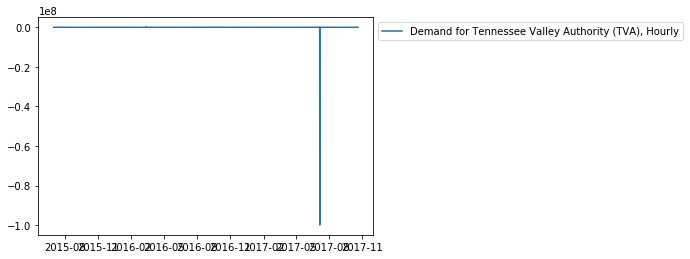

In [46]:
plot_data_frame(df_eba_tot[7:8])
#plot_data_frame(df_eba_tot)

In [52]:
d0=df_eba_tot[7:8]['data2']
np.argmax(d0)

ValueError: setting an array element with a sequence.

In [34]:
i0=0
d0=df_eba_tot.iloc[i0*3]['data2'];  #Generation
d1=df_eba_tot.iloc[i0*3+1]['data2'];  #Actual Demand
d2=df_eba_tot.iloc[i0*3+2]['data2'];  #Day ahead demand forecast

KeyError: 'data2'

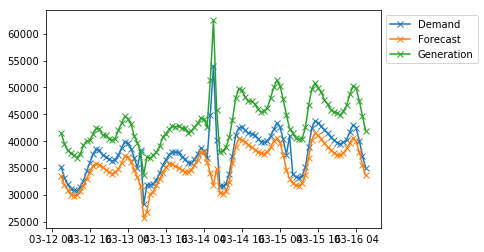

In [33]:
#check for weird points.  This plot is fore the region of maximum discrepency between the forecast and actual demand.
t0=np.argmax(abs(d2-d1))
delta=pd.Timedelta(2,'D');
t1 = t0-delta;
t2= t0+delta;
trange=pd.DatetimeIndex(start=t1,end=t2,freq='H')
pl.plot(trange,d1[trange],'-x',label='Demand')
pl.plot(trange,d2[trange],'-x',label='Forecast')
pl.plot(trange,d0[trange],'-x',label='Generation')
pl.legend(loc='upper left',bbox_to_anchor=(1,1))
pl.show()


In [ ]:
So that wasn't an error, but a real spike in demand.  Obviously the generation made up the difference.

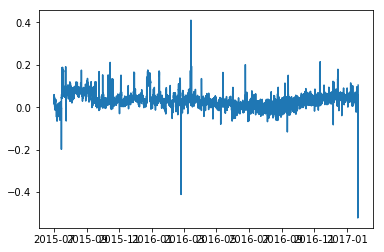

In [34]:

pl.plot(1-d2/d1)
pl.show()

Finally (months after I first wanted to do this), we can start looking at some data.  
I would like to review the sources of electricity to get a sense of seasonal variations (in terms of availability and use).  For example, I'd expect solar generation to be largest in summer, lowest in winter.  
I would assume this varies geographically.  I'll assume the seasonality can be averaged over by using the annual data. 

Residential Use will be largest in winter, barring the occasional fluctuation in summer.  

The purpose of this survey is to identify the scale of renewables in the market.  
How large a share do renewables (solar, hydro, wind) take up?  How does this vary regionally?  Over time? 
Who are the primary users of electricity?  
I'll assume the base load is provided by coal, gas and nuclear plants.  


Ultimately however, I intend to try my hand at some machine learning projects relevant to electricity.  
The first project involves demand forecasting.  The other place where data science (and nifty math) may have a role in this, is on the market.  While I am comfortable with stochastic calculus etc, I would need to learn about options pricing
and the relevant techniques for this sector of the energy market.

This is meant to be a brief background piece for that.  Since we are forecasting a time series,
I aim to use TensorFlow with some form of neural network (perhaps recurrent) to try forecasting.
Ideally, I would cross-reference the electricity data sets against the published weather forecasts for a given day.  
The model should be able to predict demand given the location, time of year, and weather forecast.  (This is probably the 
simplest thing available)

From a smart-grid perspective, how can randomly fluctuating sources, such as solar and wind, be included 
in supplying power to the grid?  